# Adventures in P-Typing
### Using Natural Language Processing and Data Science to Explore the Myers-Briggs Personality Test

## Introduction

The Myers-Brigs Type Indicator (MBTI) is a self-assessment questionnaire which helps people gain insight into how they work and learn. The test was developed by the mother-daughter partnership of Katharine Briggs and Isabel Briggs-Myers and is based on the typological theory of Carl Jung. The length of the test can range from 93 to 222 items that serve to identify a participant's personality type based on four key preferences on how they interract and deal with the world around them. 

These preferances are between the following traits:
1. Extraversion (E) vs Introversion (I)
2. Sensing (S) vs Intuition (N)
3. Thinking (T) vs Feeling (F)
4. Judging (J) vs Prospecting (P) 

The combination of these 4 preferences will determine which personality type a person would fall into. For example, an Extroverted, Sensing, Thinking, Judging person would be categorized as an ESTJ personality type. This particular type is labeled the "Executive" and is described as being dedicated, strong-willed, direct, loyal, patient, reliable, and well-ordered.   

There are 16 types in total as well as another category that indicates the level of confidence one has in their abilities which ranges from Assertive (A) to Turbulent (T). But for the purposes of this project, that last category will be left out.

## The Project

As a person who has spent years working in the educational field, I feel that knowing the personality types of your students can be an invaluable asset. Knowing that your class is predominately introverted vs extroverted can be key to lesson planning and assessment. 

Thus, my intent is to use text samples from the different personality types to build a predictive model that would be accessable and easy for a teacher to use. With the knowledge of their student's, a teacher would be better able to cater to their students' needs and preferences. 

## The Dataset

I found this [dataset](https://www.kaggle.com/datasnaek/mbti-type) on the Kaggle website. It is a collection of the last 50 forum posts from 8675 members of the [Personality Cafe](http://personalitycafe.com) community. Personality Cafe is an online platform that describes itself as "a community dedicated to helping you develop your personality through interactions with people who have the same personality as you".

I find it fascinating that such a group exists. I'm tempted to join it myself after taking the test and being categorized as an INFP (Introvert, Intuitive, Feeling, Prospecting) also know as the 'Mediator'. The 'Mediator' profile was eerily accurate and I found myself in the company of my favorite playwright, William Shakespeare. It also explained many of my personality quirks and helped me put my own career path into pespective. 

Interestingly enough, two of my best friends also ended up testing as INFPs. Although with a recent retest, they both switched over to INFJ, the 'Advocate'. 

## The Analysis

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_download = pd.read_csv('mbti_1.csv')

In [3]:
data = data_download.copy()

We start with 2 columns and 8675 rows of data. One column is the represents the personality type and the other is represents the posts.

In [4]:
print(data.shape)
pd.options.display.max_colwidth = 100
data.head()

(8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...


### Initial Exploration

The graph below indicates that there is a vast imbalance in the representation of the different personality types.  This does not bode well for building a model that is capable of accurately predicting the different categories.

The biggest group, INFP, has over 1,750 samples whereas the smallest group, ESTJ, has less than 50. I find it fascinating that these two groups are the exact opposite of one another. INFP stands for __I__ntrovert, I__n__tuitive, __F__eeling, and __P__rospecting while ESTJ stands for __E__xtrovert, __S__ensing, __T__hinking, and __J__udging. Perhaps it is the polarization of their traights that led them to being represented as such. 

I also find it interesting that the top four groups start with IN (Introvert/Intuitive) while the bottom four start with ES (Extrovert/Sensing). It would make sense that introverted people would spend more time communicating with other via these message boards while entroverts would prefer to interract with people in person. Also, it would be more likely that Intuitive people would enjoy the theoretical and complex topic of personality while sensing people maybe turned off by its lack of concrete definition.

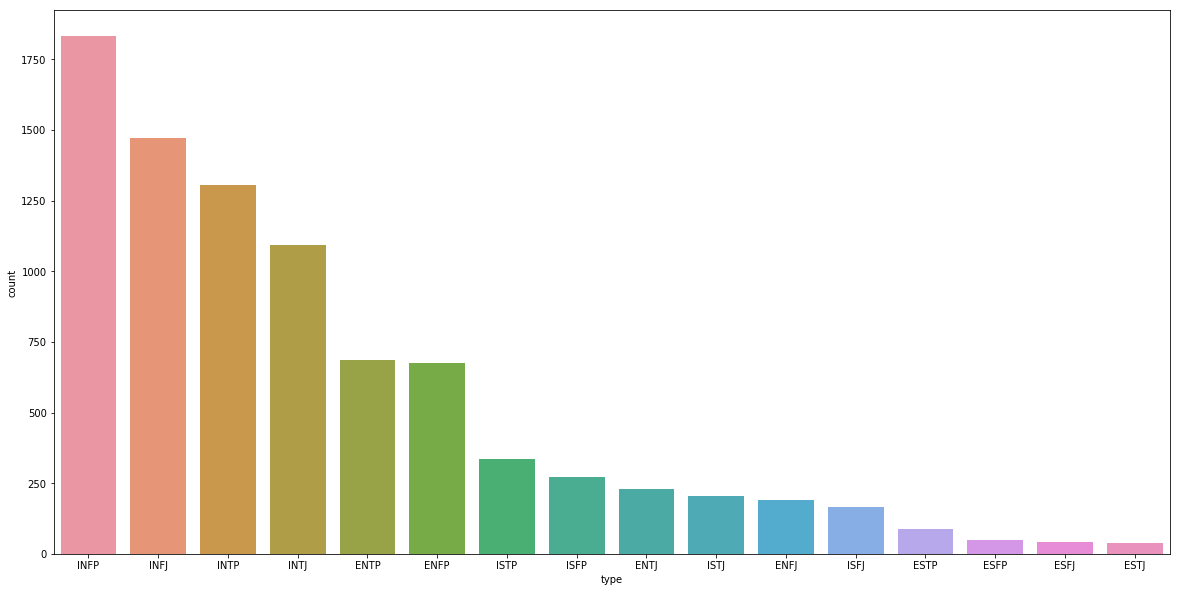

In [5]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.countplot(x="type", data=data, order = data.type.value_counts().index)
plt.show()

Below is a bigger look at the text.

I see that I'll have to get rid of the ||| separators and a few embedded links. I will replace the links with 'https' since the presence of links may be a useful predictive feature.

I see too that the writer mentions their personality classification. In this case, 'ENTP'. I will remove that since I would like to create a model that can predict the personality classification of people who are not aware of their classifications. Although even with the ommision of the types, I'm certain that this self awareness and the fact that these posts come from a forum where people explore and discuss the meaning of their personality types would still play a factor in the success of the model. 

In [6]:
pd.options.display.max_colwidth = 1000
print(data.loc[1,['posts']])

posts    'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/60

### Processing the Data

As with all text samples, there is some data processing to be done.

For clean up, I will do the following:

1.  replace urls with 'https'
2.  punctuation removal (and other random symbols)
3.  remove digits 
4.  lowercase and stop word removal
5.  remove excess white space
6.  remove the types

In [7]:
import re
from string import punctuation
from nltk.corpus import stopwords

In [8]:
def remove_url(x):
    x = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', 'https', x)
    return x
data.posts = data.posts.apply(remove_url)

In [9]:
punctuation_symbols = []

for each in list(punctuation):
    punctuation_symbols.append((each, ' '))
    
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
    return x

data.posts = data.posts.apply(remove_puncuation)

In [10]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

data.posts = data.posts.apply(remove_digits)

In [11]:
stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

data.posts = data.posts.apply(remove_stop_words)

In [12]:
def remove_extra_white_space(x):
    x = ' '.join(x.split())
    return x

data.posts = data.posts.apply(remove_extra_white_space)

Through several iterations of my project, I realized that not only would I need to remove the category labels but also some Myers-Briggs abbreviations such as 'e', 'j', 'p', 'ne', 'ti', and 'si'. 

I have included them below and will continue to remove more as I discover them as I continue working with this data set.

In [13]:
def remove_types(x):
    x = re.sub(r'(i|e)(n|s)(t|f)(j|p)\w*|\b(ne|sx|ni|ti|fe|nt|se|si|nf)\b', '', x)
    return x

data.posts = data.posts.apply(remove_types)

In [14]:
pd.options.display.max_colwidth = 1000
print(data.loc[1,['posts']])

posts    finding lack posts alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello  grin takes converse flirting acknowledge presence return words smooth wordplay cheeky grins lack balance hand eye coordination real iq test score internet iq tests funny score higher like former responses thread mention believe iq test banish know  vanish site year half return find people still commenting posts liking ideas thoughts know  https think things sometimes go old sherlock holmes quote perhaps man special knowledge special powers like rather encourages seek complex cheshirewolf tumblr com post really never thought e j p real functions judge use use   dominates  emotions rarely  also use  due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best makes lol guys lucky really high tumblr system hear new first

## Predictive Model Using TF-IDF Words as Features

I will now use the cleaned up texts and input them into the TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer. I did use both this and the 'bag of words' method and found that the TF-IDF method gave me a slightly better accuracy score. Which isn't surprising given that TF-IDF gives a greater weight to words that don't appear as often throughout the text.

With the TF-IDF processed texts, I will create my predictive models.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0.02, stop_words = 'english', norm='l2')

In [17]:
# fit & transform
tfidf_matrix = tf.fit_transform(data.posts)

print('Number of documents:', tfidf_matrix.shape[0], ', number of features:', tfidf_matrix.shape[1])

Number of documents: 8675 , number of features: 3459


In [18]:
tfidf_feature_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
tfidf_feature_matrix.head()

,abilities,ability,able,absolute,absolutely,absolutely love,abstract,absurd,abuse,abusive,...,yes yes,yesterday,yo,young,younger,youth,youtube,yup,zero,zone
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.083409,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.031013,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.108889,0.037769,0.000000,0.091012,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.069786,0.0,0.0
3,0.0,0.000000,0.064068,0.060195,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Below are my first two models. 

I chose to go with the Random Forest and Logistic Regression Models.

I did attempt them with Gradient Boosting and Support Vector Machines. The Gradient Boosting took far too long, so I stopped it before it could finish. The Support Vector Machine took about 15 minutes and yielded results similiar to the logistic regression model.

In [19]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

In [20]:
X = tfidf_feature_matrix
Y = data['type']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc.score(X_train, Y_train))
print('Test set score:', rfc.score(X_test, Y_test)) 


Random Forest Classifier:
Training set score: 0.990777743621
Test set score: 0.200553250346


In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr.score(X_train, Y_train))
print('Test set score:', lr.score(X_test, Y_test))


Logistic Regression:
Training set score: 0.583922533046
Test set score: 0.359612724758


As somewhat expected, neither the Random Forest Classifier nor the Logistic Regression models did very well. This is primarily due to the fact that several of the groups were ill represented. 

The following confusion matrix supports that hypothesis as the 'IN' personality types are the ones that were identified most often. INFP, for example, had a 70% recall score. But that is only because the model kept predicting the category due to its high level of representation. Because of this, the INFP precision score suffered at 40% accuracy as 60% of the samples that were identified as INFP were actually some other category. 

Several of the other categories had ZERO recall and precision scores. This is due to their severe lack of representation. The model didn't even bother to even predict their precence at all. 

ISTJ and ISTP both had 100% precision but that is due such a low number of predictions made by the model in favor of those two categories. Meanwhile, their recall scores were just 1-2%. So the vast majority of the ISTJ and ISTP samples were left unidentified. 

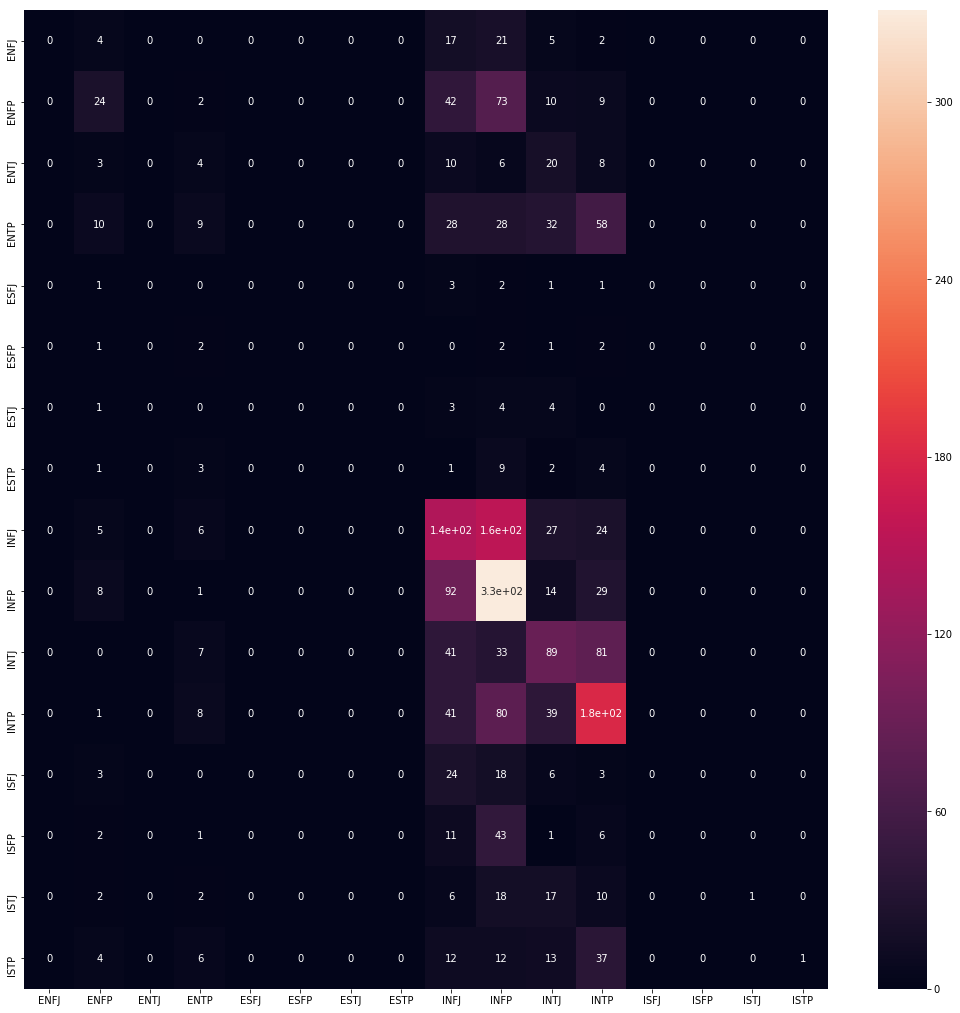

             precision    recall  f1-score   support

       ENFJ       0.00      0.00      0.00        49
       ENFP       0.34      0.15      0.21       160
       ENTJ       0.00      0.00      0.00        51
       ENTP       0.18      0.05      0.08       165
       ESFJ       0.00      0.00      0.00         8
       ESFP       0.00      0.00      0.00         8
       ESTJ       0.00      0.00      0.00        12
       ESTP       0.00      0.00      0.00        20
       INFJ       0.30      0.40      0.34       361
       INFP       0.40      0.70      0.51       475
       INTJ       0.32      0.35      0.33       251
       INTP       0.40      0.52      0.45       350
       ISFJ       0.00      0.00      0.00        54
       ISFP       0.00      0.00      0.00        64
       ISTJ       1.00      0.02      0.04        56
       ISTP       1.00      0.01      0.02        85

avg / total       0.34      0.36      0.30      2169



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
from sklearn.metrics import confusion_matrix
personality_types = sorted(data.type.unique())

Y_pred = lr.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (18,18))
sns.heatmap(df_cm, annot=True)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, target_names=personality_types))

---
## Predictive Models Based on Individual Traits 

Upon reflection and the suggestion of my mentor, I decided to create new columns that would identify each sample by their individual traits. Meaning, I would have a separate column for Introvert/Extrovert, Intuitive/Sensing, Thinking/Feeling, and Judging/Prospecting.

In [24]:
tfidf_feature_matrix2 = tfidf_feature_matrix.copy()

In [25]:
tfidf_feature_matrix2['type_IE'] = [x[0] for x in data.type]
tfidf_feature_matrix2['type_NS'] = [x[1] for x in data.type]
tfidf_feature_matrix2['type_TF'] = [x[2] for x in data.type]
tfidf_feature_matrix2['type_JP'] = [x[3] for x in data.type]

In [26]:
tfidf_feature_matrix2.head()

,abilities,ability,able,absolute,absolutely,absolutely love,abstract,absurd,abuse,abusive,...,younger,youth,youtube,yup,zero,zone,type_IE,type_NS,type_TF,type_JP
0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,I,N,F,J
1,0.0,0.000000,0.031013,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,E,N,T,P
2,0.0,0.108889,0.037769,0.000000,0.091012,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.069786,0.0,0.0,I,N,T,P
3,0.0,0.000000,0.064068,0.060195,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,I,N,T,J
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,E,N,T,J


Below is a breakdown of how balanced the number of samples are in each pair. The most even numbered being Thinking/Feeling while the least being Intuitive/Sensing. 

I    6676
E    1999
Name: type_IE, dtype: int64 

N    7478
S    1197
Name: type_NS, dtype: int64 

F    4694
T    3981
Name: type_TF, dtype: int64 

P    5241
J    3434
Name: type_JP, dtype: int64 



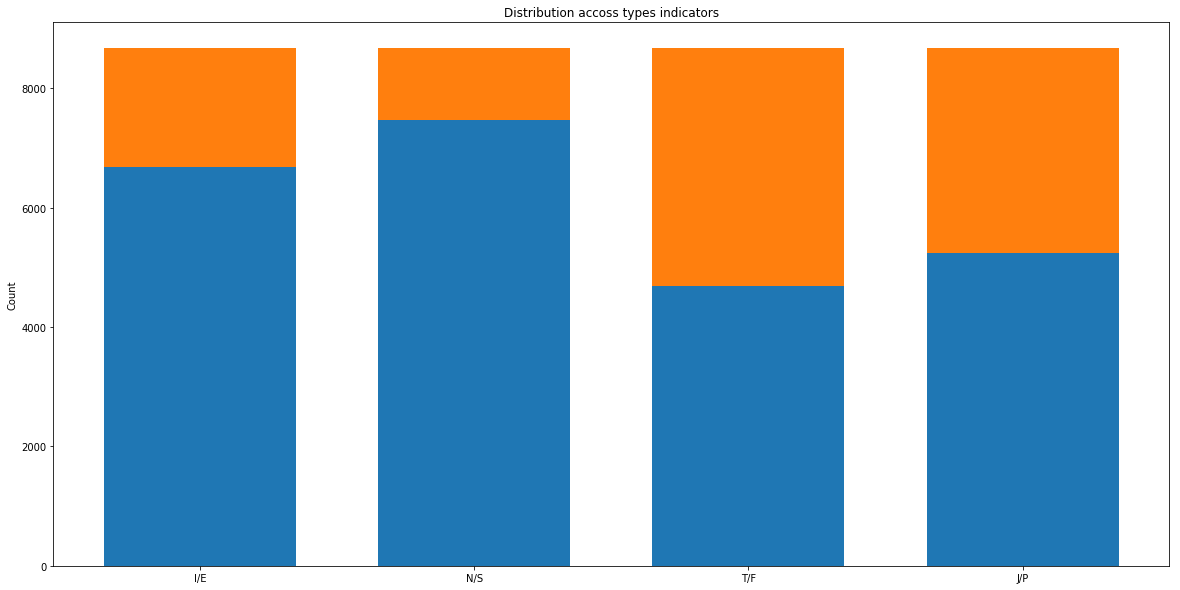

In [27]:
print(tfidf_feature_matrix2.type_IE.value_counts(), '\n')
print(tfidf_feature_matrix2.type_NS.value_counts(), '\n')
print(tfidf_feature_matrix2.type_TF.value_counts(), '\n')
print(tfidf_feature_matrix2.type_JP.value_counts(), '\n')

N = 4
but = (tfidf_feature_matrix2.type_IE.value_counts()[0], tfidf_feature_matrix2.type_NS.value_counts()[0], 
       tfidf_feature_matrix2.type_TF.value_counts()[0], tfidf_feature_matrix2.type_JP.value_counts()[0])
top = (tfidf_feature_matrix2.type_IE.value_counts()[1], tfidf_feature_matrix2.type_NS.value_counts()[1], 
       tfidf_feature_matrix2.type_TF.value_counts()[1], tfidf_feature_matrix2.type_JP.value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

I will do a random sampling of Introvert/Extrovert, Intuitive/Sensing, and Judging/Prospecting to get a more balanced set of numbers. I'm sure, however, that these models won't do as well due to the smaller sample sizes.

The Thinking/Feeling samples will be left alone since they are well balanced. 

I will do them in order of sample sizes from smallest to biggest.

### Intuitive/Sensing Model:

In [28]:
data_N = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_NS'] == 'N'].sample(n=1197)
print(data_N.shape)
data_S = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_NS'] == 'S']
print(data_S.shape)
data_NS = pd.concat([data_N, data_S])
print(data_NS.shape)

(1197, 3463)
(1197, 3463)
(2394, 3463)


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

drop_list = ['type_IE','type_NS',"type_TF",'type_JP']


Random Forest Classifier:
Training set score: 0.98495821727
Cross Validation Scores:  [ 0.56666667  0.57291667  0.53556485  0.55857741  0.5041841 ]
Average score:  0.547581938633

Logistic Regression:
Training set score: 0.889136490251
Cross Validation Scores:  [ 0.67916667  0.65        0.67782427  0.67573222  0.65690377]
Average score:  0.667925383543


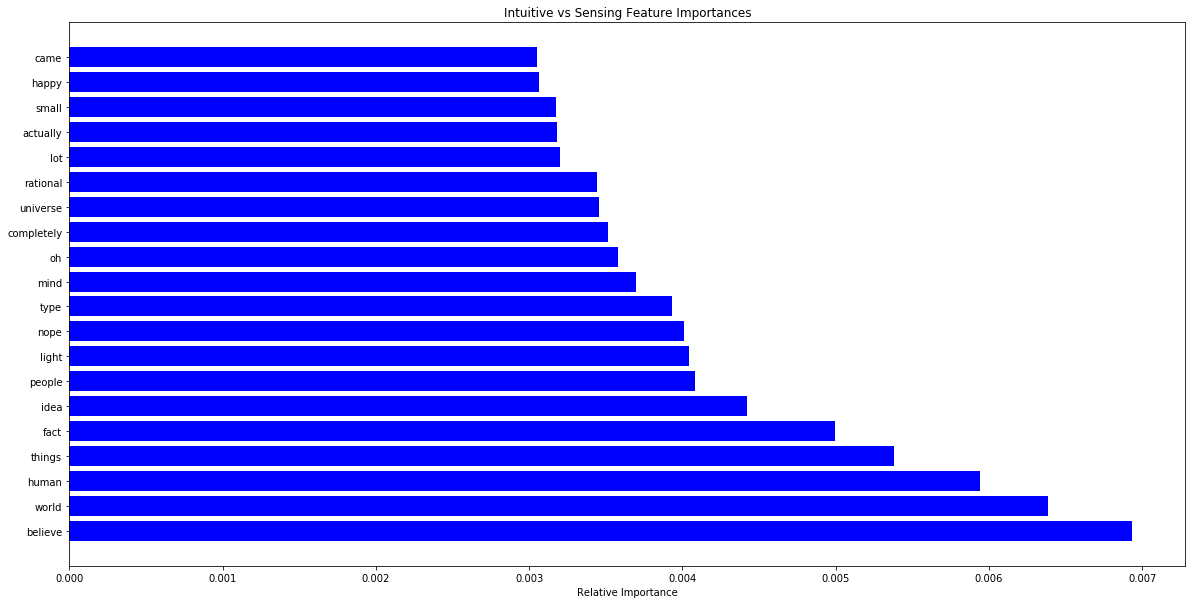

In [79]:
Y = data_NS['type_NS']
X = data_NS.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_NS = ensemble.RandomForestClassifier()

rfc_NS.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_NS.score(X_train, Y_train))
rfc_scores_NS = cross_val_score(rfc_NS, X, Y, cv=5)
print('Cross Validation Scores: ' , rfc_scores_NS )  
print('Average score: ', np.mean(rfc_scores_NS))

lr_NS = LogisticRegression()
lr_NS.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_NS.score(X_train, Y_train))
lr_scores_NS = cross_val_score(lr_NS, X, Y, cv=5)
print('Cross Validation Scores: ' , lr_scores_NS)
print('Average score: ', np.mean(lr_scores_NS))

features = X.columns
importances = rfc_NS.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Intuitive vs Sensing Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

With an average Random Forest Score of about 0.55 and Logistic Regression score of 0.67, this model didn't do too well. Although the feature importance taken from the Random Forest Model did offer some insight. 

Intuitive vs Sensing refers to how a person takes in information. As the name would imply, a sensing person has a preference for accessing information through their senses. Basically, what they can see, hear, touch, taste, and smell. An intuitive person would try to gain knowledge beyond the concrete senses and will interpret information through more abstract ideas and feelings. Not just solely on what's right in front of them. 

It is appropriate then that some of the key features would be the words 'believe', 'fact', and 'idea'. 

Admittedly, the other top features where not stable at all. That is probably due to the small sample size of 1197 for both I and S. But 'believe', 'fact', and 'idea' were consistently in the top 20.

The confusion matrix below based off of the Logistic Regression model was consistent with the average scores.

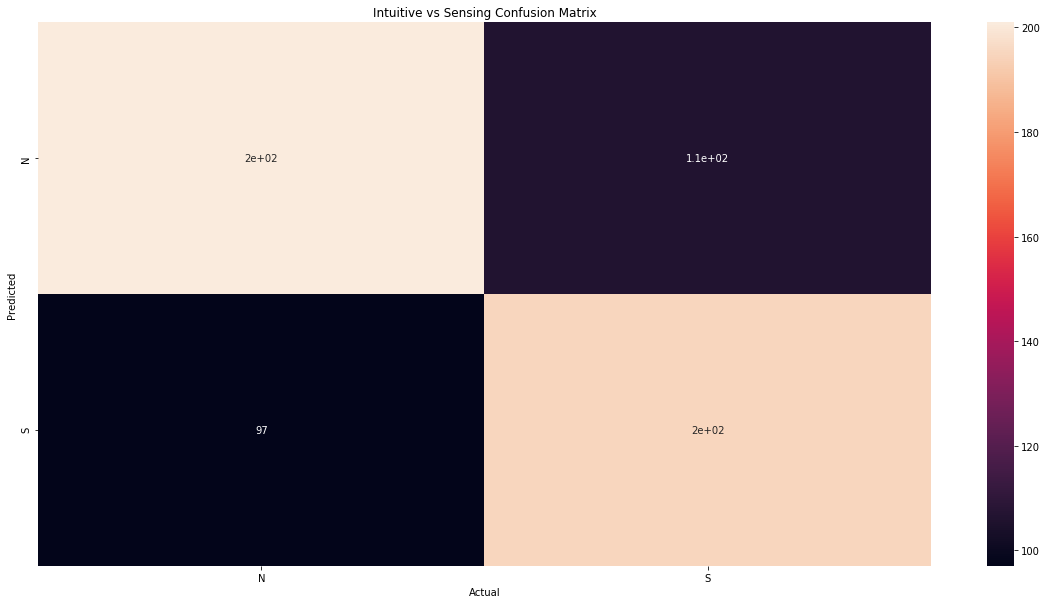

             precision    recall  f1-score   support

          N       0.65      0.67      0.66       298
          S       0.67      0.65      0.66       301

avg / total       0.66      0.66      0.66       599



In [64]:
personality_types_NS = sorted(data_NS.type_NS.unique() )

Y_pred = lr_NS.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types_NS],
                  columns = [i for i in personality_types_NS])

plt.figure()
sns.heatmap(df_cm, annot=True)
plt.title('Intuitive vs Sensing Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

print(classification_report(Y_pred, Y_test,  target_names=personality_types_NS))

---
### Introverted/Extroverted Model:

In [32]:
data_I = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_IE'] == 'I'].sample(n=1999)
print(data_I.shape)
data_E = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_IE'] == 'E']
print(data_E.shape)
data_IE = pd.concat([data_I, data_E])
print(data_IE.shape)

(1999, 3463)
(1999, 3463)
(3998, 3463)



Random Forest Classifier:
Training set score: 0.989326217478
Cross Validation Scores: [ 0.5075      0.585       0.58125     0.55625     0.58270677]
Average Score:  0.562541353383

Logistic Regression:
Training set score: 0.845897264843
Cross Validation Scores:  [ 0.66625     0.675       0.695       0.67875     0.67042607]
Average Score:  0.677085213033


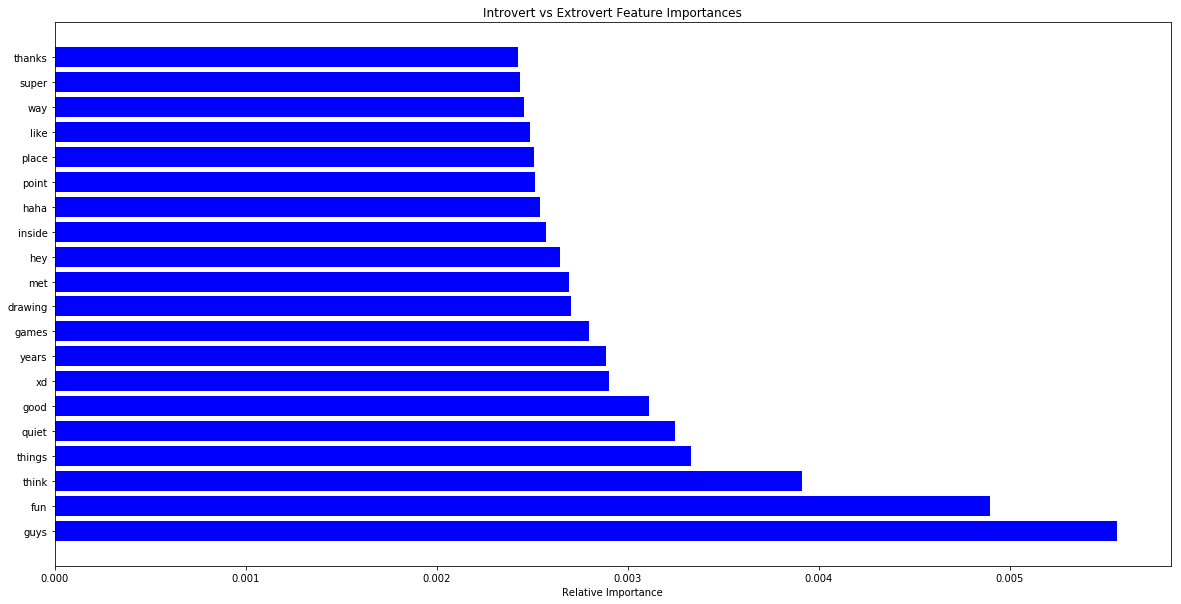

In [82]:
Y = data_IE['type_IE']
X = data_IE.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_IE = ensemble.RandomForestClassifier()

rfc_IE.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_IE.score(X_train, Y_train))
rfc_score_IE = cross_val_score(rfc_IE, X, Y, cv=5)
print('Cross Validation Scores:' , rfc_score_IE)
print('Average Score: ', np.mean(rfc_score_IE))

lr_IE = LogisticRegression()
lr_IE.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_IE.score(X_train, Y_train))
lr_score_IE = cross_val_score(lr_IE, X, Y, cv=5)
print('Cross Validation Scores: ' , lr_score_IE)
print('Average Score: ', np.mean(lr_score_IE))

features = X.columns
importances = rfc_IE.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Introvert vs Extrovert Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

The Introvert vs Extrovert model did about as well as the Intuitive vs Sensing model.

Contrary to popular belief, introversion vs extroversion isn't about shyness. It has more to do with how much social stimulation a person can sustain before starting to tire. An introverted person has a low threshold for stimulation and thus can't spend too much time in large and busy social situations. An extroverted person, on the other hand, would thrive in such a situation since they require and enjoy the extra stimulation. 

There were a few features that did show up consistantly, although not everytime, in the top 20 that I found to be insightful. Words like 'fun', 'friends', 'bored' and 'lol' could indicate a more extroverted personality while words like 'think' and 'quiet' could be associated with introversion.

The confusion matrix was in accordance with the above scores.

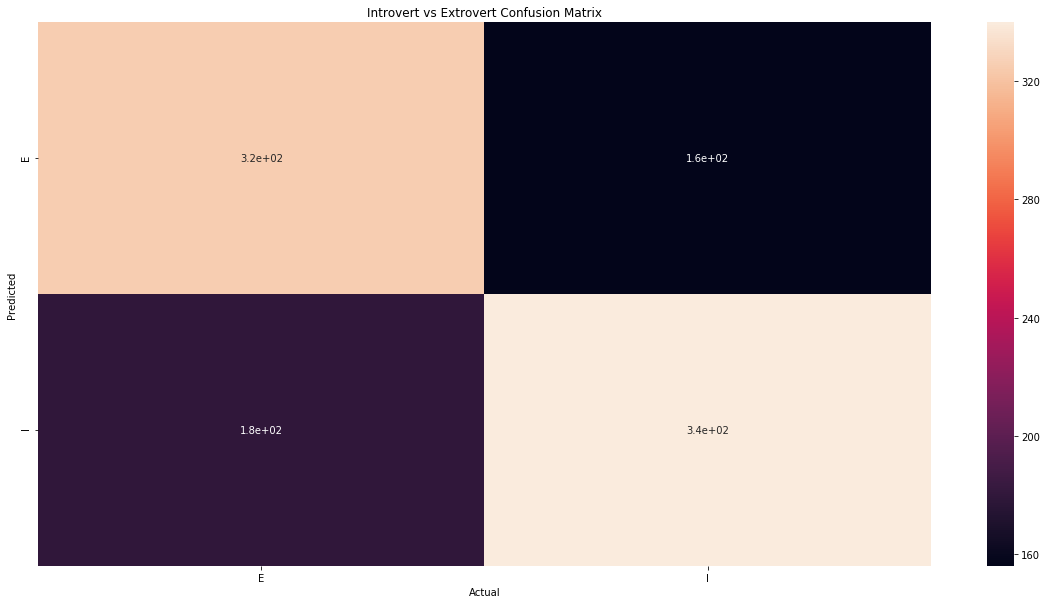

             precision    recall  f1-score   support

          E       0.68      0.64      0.66       504
          I       0.66      0.69      0.67       496

avg / total       0.67      0.67      0.66      1000



In [66]:
personality_types_IE = sorted(data_IE.type_IE.unique() )

Y_pred = lr_IE.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types_IE],
                  columns = [i for i in personality_types_IE])

plt.figure()
sns.heatmap(df_cm, annot=True)
plt.title('Introvert vs Extrovert Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

print(classification_report(Y_pred, Y_test,  target_names=personality_types_IE))

---
### Judging/Prospecting Model:

In [45]:
data_P = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_JP'] == 'P'].sample(n=3434)
print(data_P.shape)
data_J = tfidf_feature_matrix2.loc[tfidf_feature_matrix2['type_JP'] == 'J']
print(data_J.shape)
data_JP = pd.concat([data_J, data_P])
print(data_JP.shape)

(3434, 3463)
(3434, 3463)
(6868, 3463)



Random Forest Classifier:
Training set score: 0.98738109105
Cross Validation Scores:  [ 0.53129549  0.5363901   0.52765648  0.5342067   0.52332362]
Average Scores:  0.530574475579

Logistic Regression:
Training set score: 0.805086390992

Cross Validation Scores:
 [ 0.63027656  0.62299854  0.62081514  0.6411936   0.64504373]
Average Scores:  0.632065514915


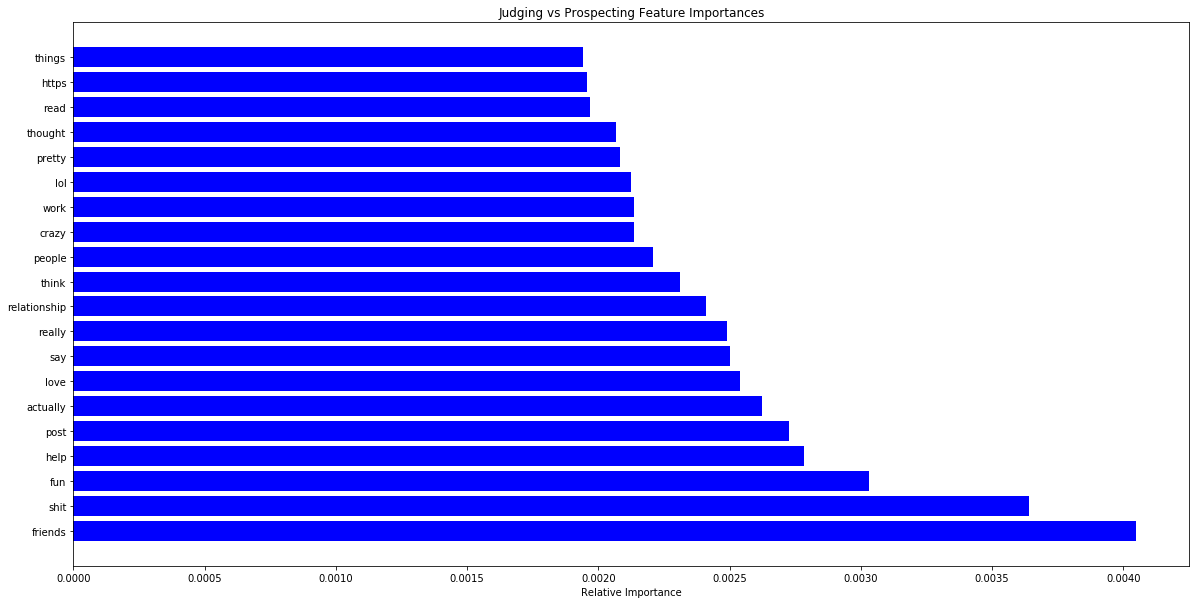

In [85]:
Y = data_JP['type_JP']
X = data_JP.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_JP = ensemble.RandomForestClassifier()

rfc_JP.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_JP.score(X_train, Y_train))
rfc_scores_JP = cross_val_score(rfc_JP, X, Y, cv=5)
print('Cross Validation Scores: ' , rfc_scores_JP)
print('Average Scores: ', np.mean(rfc_scores_JP))

lr_JP = LogisticRegression()
lr_JP.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_JP.score(X_train, Y_train))
lr_scores_JP = cross_val_score(lr_JP, X, Y, cv=5)
print('\nCross Validation Scores:\n' , lr_scores_JP)
print('Average Scores: ', np.mean(lr_scores_JP))

features = X.columns
importances = rfc_JP.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Judging vs Prospecting Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Despite having more samples, the Judging vs Prospecting model did unexpectedly worse than the previous two. 

This maybe due to the nature of the two traits. To clarify, the word Judging as it is used in this context isn't about forming an opinion or conclusion about something. Instead, it has to do with how structured a person is. According the Myers-Briggs, a judging person likes to make plans and stay organized. In contrast to that, a prospecting person likes to keep their options open and be spontaneous.

This may be why the model did worse even though it had more samples. Since a person would demonstrate this in their writing more by the stucture and style of their writing as opposed to their word choice.

The feature importance as well was completely instable where the same words rarely showed up consistently and none of them made any sense. 

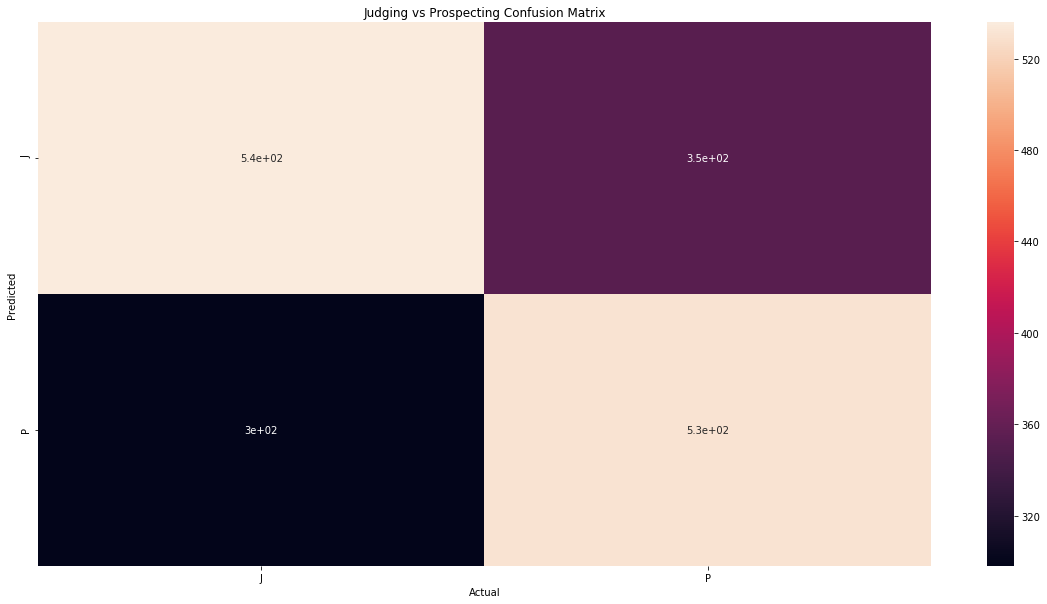

             precision    recall  f1-score   support

          J       0.60      0.64      0.62       834
          P       0.64      0.60      0.62       883

avg / total       0.62      0.62      0.62      1717



In [68]:
personality_types_JP = sorted(tfidf_feature_matrix2.type_JP.unique())

Y_pred = lr_JP.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types_JP],
                  columns = [i for i in personality_types_JP])

plt.figure()
sns.heatmap(df_cm, annot=True)
plt.title('Judging vs Prospecting Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

print(classification_report(Y_pred, Y_test,  target_names=personality_types_JP))

---
### Thinking/Feeling Model:


Random Forest Classifier:
Training set score: 0.988164770981
Cross Validation Scores:  [ 0.64343318  0.64092219  0.60057637  0.62305476  0.6372549 ]
Average Score:  0.629048279161

Logistic Regression:
Training set score: 0.861512450046

Cross Validation Scores:
 [ 0.81278802  0.78847262  0.78270893  0.78789625  0.78200692]
Average Score:  0.790774549729


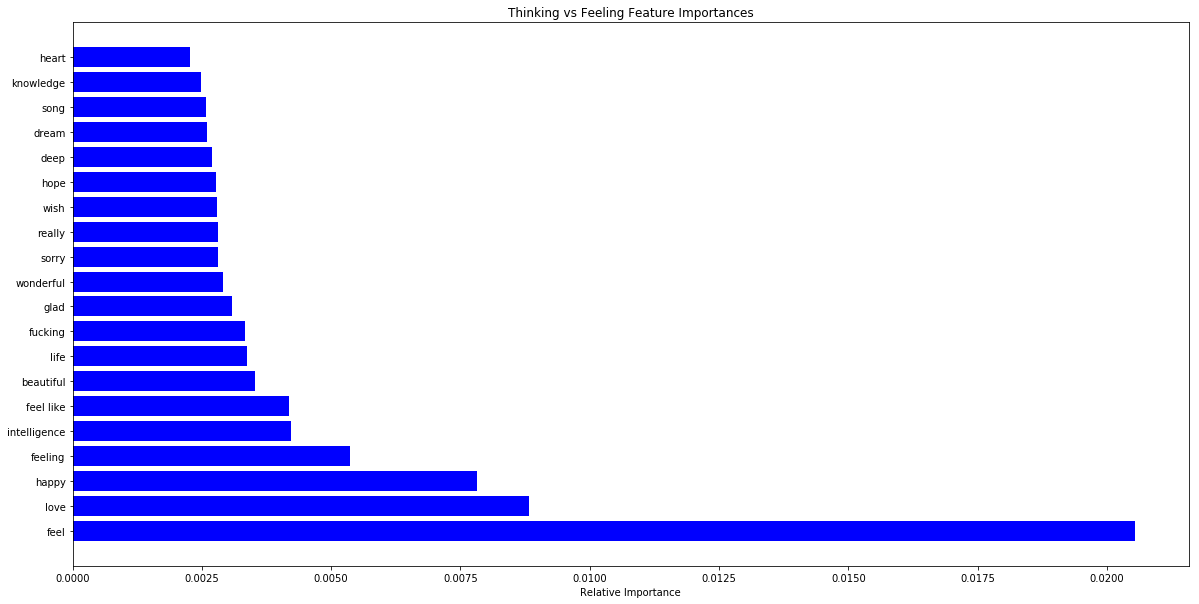

In [87]:
Y = tfidf_feature_matrix2['type_TF']
X = tfidf_feature_matrix2.drop(drop_list, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

rfc_TF = ensemble.RandomForestClassifier()

rfc_TF.fit(X_train, Y_train)

print('\nRandom Forest Classifier:')
print('Training set score:', rfc_TF.score(X_train, Y_train))
rfc_scores_TF = cross_val_score(rfc_TF, X, Y, cv=5)
print('Cross Validation Scores: ' , rfc_scores_TF)  
print('Average Score: ', np.mean(rfc_scores_TF))

lr_TF = LogisticRegression()
lr_TF.fit(X_train, Y_train)

print('\nLogistic Regression:')
print('Training set score:', lr_TF.score(X_train, Y_train))
lr_scores_TF = cross_val_score(lr_TF, X, Y, cv=5)
print('\nCross Validation Scores:\n' , lr_scores_TF)
print('Average Score: ', np.mean(lr_scores_TF))

features = X.columns
importances = rfc_TF.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20
indices = indices[:top_k]

plt.title('Thinking vs Feeling Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

This model did by far the strongest which makes sense given that it had the biggest sample size. 

The feature importance was also very stable. Thinking vs Feeling is more about how a person makes  their decisions. A Thinking person will base decisions solely on facts and are very absolute in their judgments. They see things in black or white. A Feeling person will base their decisions on how it would affect others. They take a more relative stance on issues and are more willing to bend the rules for the benefit of others.   

Thus, words like 'feel', feeling' and 'feel like' would point to a Feeling person whereas 'think' and 'knowledge' would indicate a Thinking person.

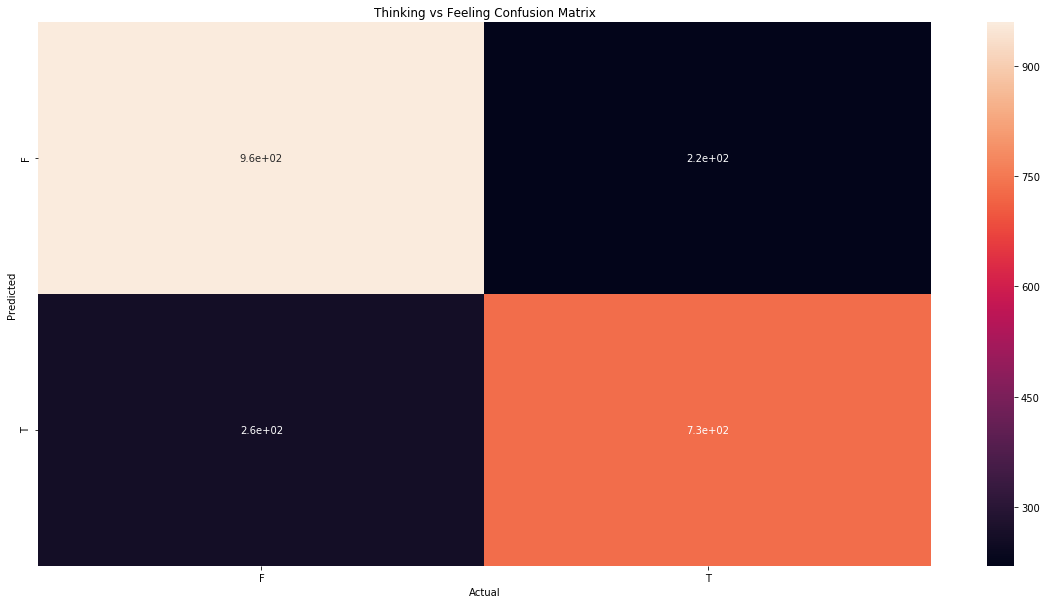

             precision    recall  f1-score   support

          F       0.81      0.79      0.80      1217
          T       0.74      0.77      0.75       952

avg / total       0.78      0.78      0.78      2169



In [70]:
personality_types_TF = sorted(tfidf_feature_matrix2.type_TF.unique())

Y_pred = lr_TF.predict(X_test)
confusion_array = confusion_matrix(Y_test, Y_pred)

df_cm = pd.DataFrame(confusion_array, index = [i for i in personality_types_TF],
                  columns = [i for i in personality_types_TF])

plt.figure()

sns.heatmap(df_cm, annot=True)
plt.title('Thinking vs Feeling Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

print(classification_report(Y_pred, Y_test,  target_names=personality_types_TF))

## Twitter Application

With these 4 models, I created a Twitter application that will take a person's Twitter handle and return their personality type.

In [50]:
import tweepy

ckey = "zLceR2GtRk7LiUMXRzLAYQ1ML"
csecret = "gUQWOfGKI7voYlfLD5rpl5KiQrXQTpzIQXLmPjsaYQO3cGhefo"
atoken = "819671108-WsXdRIP2tk9oBbh9ISPXAnKfVv567xPX1OsBDfSt"
asecret = "FSGAGxj2atE2HKqGlLYUS3KC9NGtzc8akeqlNBDrfgc1C"

auth = tweepy.OAuthHandler(ckey, csecret)

In [52]:
def get_twitter_type(twitter_handle):
    auth.set_access_token(atoken, asecret)

    api = tweepy.API(auth)

    stuff = api.user_timeline(screen_name = twitter_handle, count = 300, include_rts = False)

    twitter_text = ''
    for status in stuff:
        twitter_text += status.text
        twitter_text += ' '

    twitter_text = remove_url(twitter_text)
    twitter_text = remove_puncuation(twitter_text)
    twitter_text = remove_digits(twitter_text)
    twitter_text = remove_stop_words(twitter_text)
    twitter_text = remove_extra_white_space(twitter_text)
    twitter_text = remove_types(twitter_text)

    my_tfidf_matrix2 = tf.transform([twitter_text])

    my_tfidf_feature_matrix2 = pd.DataFrame(my_tfidf_matrix2.toarray(), columns=tf.get_feature_names())
    my_tfidf_feature_matrix2.head()

    print(lr_IE.predict(my_tfidf_feature_matrix2)[0] 
          + lr_NS.predict(my_tfidf_feature_matrix2)[0] 
          + lr_TF.predict(my_tfidf_feature_matrix2)[0] 
          + lr_JP.predict(my_tfidf_feature_matrix2)[0])

I scraped Twitter for handles that included #INFP to find some test samples.

In [72]:
from langdetect import detect

MAX_TWEETS = 500

auth = tweepy.OAuthHandler(ckey, csecret)
api = tweepy.API(auth)

for tweet in tweepy.Cursor(api.search, q='#INFP', rpp=100).items(MAX_TWEETS):
    if detect(tweet._json['text']) == 'en':
      print(tweet.user.name)
    pass

❀ ιrocнιcнαɴ
❄️Snowflake❄️✍️
Bouncy Boxer Media
凸面鏡の自画像
nary 🌻.
ʷ ❀
Sunshine Girl 🌼
Kaizen
C. James the Savage
RahafKOOK


I tried it out with my own twitter handle and a few of the Twitter handles that I scraped and theres were my results:

In [88]:
get_twitter_type('VincentCleopeGo')
get_twitter_type('Vivianne Ouya')
get_twitter_type('Kaizen')
get_twitter_type('Eliza Kinde')
get_twitter_type('inkandstars')

ESFP
ESFP
ISTJ
ESFP
INFP


Of my attempts, 'Kaizen' did the worse with only 1 out of 4 correct.

My handle, 'Vivianne Ouya', and 'Eliza Kinde' yielded similar results with 2 out of 4 correct. For those, the first 2 letters were from the models with the LEAST amount of samples and were all wrong. The last letter was from the model with the worst accuracy scores but still got all of them correct. And, third letter was from the model that had the highest accuracy score and as expected were all correct.


The one that was 100% accurate was 'inkandstars'. I looked at the tweets for this handle and found that it was the most self aware. 'Inkandstars' tweeted mostly about their personality type and what it meant similiar to the posts found on Personality Cafe. Thus, I conclude that their self awareness had something to do with the success of the prediction.

## Summary

In conclusion, I feel like it is possible to refine these models to make a usable application that has an accuracy score close to 80%. 

For it to work though, more text samples would be needed and these samples should come from a source where the main reason for writing is not to discuss their personality types. Also, with more time and exploration, I'm sure there are more features outside of a TF-IDF matrix that could be included in the predictive models such as sentence length, variance of sentence length, use of punction, etc.

I'm sure that any teacher would find it handy to have a student's Myers-Briggs personality type handy. I know that it helped me to know myself better. And with that knowledge, I have made better choices that are more in line with who I am and who I want to be.